In [1]:
import pandas as pd
import glob

In [9]:
df = pd.read_csv('master_final_220708_택시요금추가.csv')

In [10]:
df.columns

Index(['cartype', '예정시간', '배차시간', '승차시간', 'startpos1', 'startpos2', 'endpos1',
       'endpos2', 'direction', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'distance', 'duration', 'taxiFare_N', 'y_b_time', 'b_s_time',
       'y_s_time', 'y_b_seconds', 'b_s_seconds', 'y_s_seconds', 'taxiFare_I',
       'taxiFare_J'],
      dtype='object')

In [12]:
df = df[['예정시간', '배차시간', '승차시간','startpos1', 'startpos2', 'endpos1',
       'endpos2','taxiFare_I','taxiFare_J']]

In [16]:
import datetime as dt

In [19]:
df['예정시간'] = pd.to_datetime(df['예정시간']).dt.strftime('%Y%m%d')
df['배차시간'] = pd.to_datetime(df['배차시간']).dt.strftime('%Y%m%d')
df['승차시간'] = pd.to_datetime(df['승차시간']).dt.strftime('%Y%m%d')

In [100]:
data = df[['예정시간', 'startpos1', 'endpos1', 'taxiFare_I']]

In [96]:
data.head()

,예정시간,startpos1,endpos1,taxiFare_I
0,20180123,성북구,동대문구,7700
1,20180123,중랑구,노원구,16200
2,20180123,성북구,강북구,8200
3,20180123,구로구,관악구,12700
4,20180123,동대문구,성북구,7300


In [97]:
from neuralprophet import NeuralProphet, set_log_level
set_log_level('ERROR')

# 노원구

In [98]:
data = data[data['startpos1']=='노원구'].groupby('예정시간').sum().reset_index()

In [101]:
data1 = data[data['startpos1']=='강서구'].groupby('예정시간').sum().reset_index()

In [102]:
data = data.rename(columns={'예정시간': 'date',
                            'taxiFare_I' : 'value'})

In [103]:
data1 = data1.rename(columns={'예정시간': 'date',
                            'taxiFare_I' : 'value'})

In [54]:
data['date'] = pd.to_datetime(data['date'])

In [104]:
data1['date'] = pd.to_datetime(data1['date'])

# 데이터 전처리 및 모델학습

In [79]:
#train test split
cutoff = "2021-07-01"
train_df = data[data['date']<cutoff]
test_df = data[data['date']>=cutoff]

In [80]:
#전용 train, test 데이터 생성
train = pd.DataFrame({"ds": train_df["date"], "y": train_df["value"]})
test = pd.DataFrame({"ds": test_df["date"], "y": test_df["value"]})

In [81]:
train.head()

,ds,y
0,2018-01-01,337200
1,2018-01-02,253900
2,2018-01-03,512500
3,2018-01-04,408300
4,2018-01-05,475800


In [82]:
test.head()

,ds,y
1277,2021-07-01,250100
1278,2021-07-02,252000
1279,2021-07-03,316100
1280,2021-07-04,459300
1281,2021-07-05,361700


In [83]:
#모델 설정
m = NeuralProphet(
    learning_rate=0.1,
    weekly_seasonality=False,
    daily_seasonality=False
)

In [84]:
#모델 학습
metrics = m.fit(train, freq = 'D')

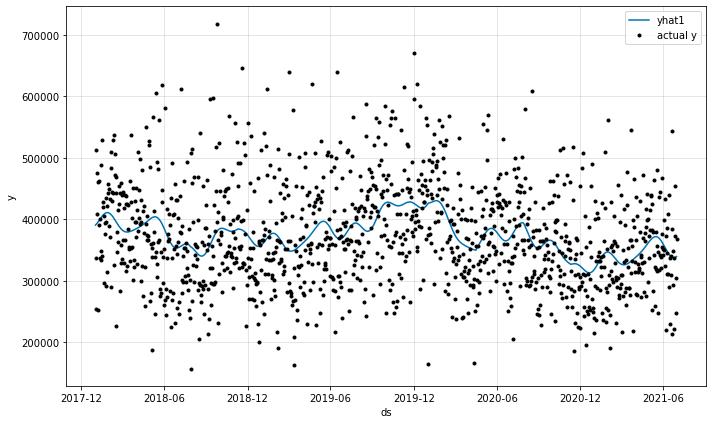

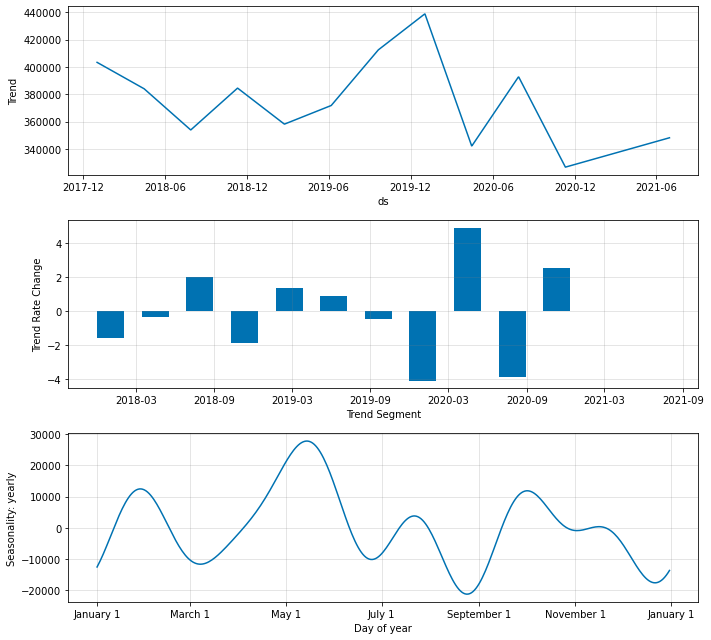

In [85]:
#학습 데이터셋 예측 결과 시각화
train_pred = m.predict(train)
#fig = m.plot(train_pred)
fig1 = m.plot(train_pred[-30*24*6:])
#fig2 = m.plot(train_pred[-7*24*6:])
#comp = m.plot_components(train_pred)
param = m.plot_parameters()

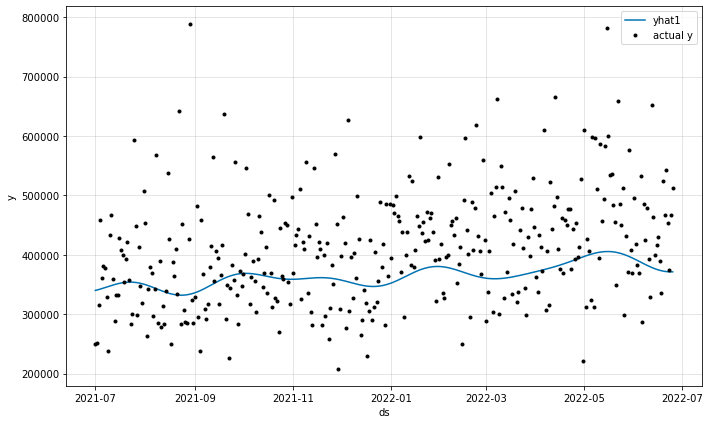

In [86]:
#테스트 데이터셋 예측 결과 시각화
test_pred = m.predict(test)
fig = m.plot(test_pred)
#fig1 = m.plot(test_pred[-14*24*6:])
#fig2 = m.plot(test_pred[-7*24*6:])
#comp = m.plot_components(test_pred)

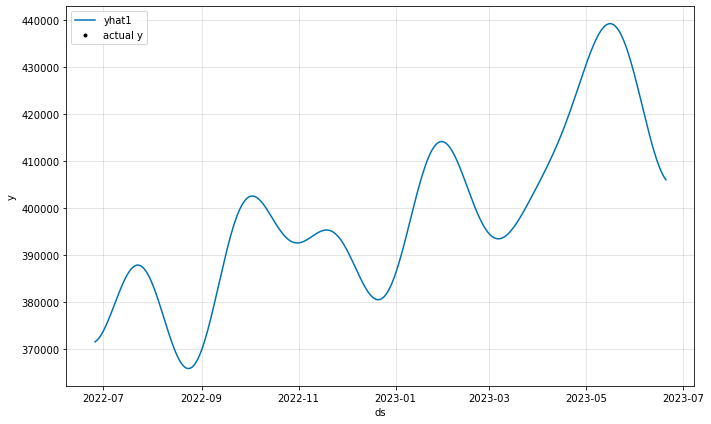

In [87]:
df_future = m.make_future_dataframe(test, periods=360)
forecast = m.predict(df_future)
fig_forecast = m.plot(forecast)

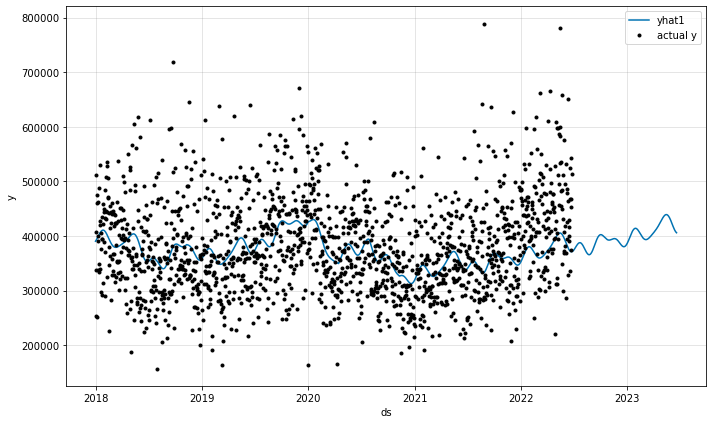

In [88]:
all_pred = pd.concat([train_pred, test_pred, forecast])
fig_all_pred = m.plot(all_pred)

In [89]:
data.describe()

,value
count,1637.000000
mean,381259.376909
std,88123.001490
min,157300.000000
25%,317300.000000
50%,369800.000000
75%,438300.000000
max,789000.000000


# 성능평가

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

col = "Appliances"

#학습 데이터셋 검증
pred2 = train_pred["y"]
test2 = train_pred['yhat1']
print("============== {} Evaluate Result============".format(col))
print("MAE :", mean_absolute_error(test2, pred2))
print("MSE :", mean_squared_error(test2, pred2))
print("RMSE :", (mean_squared_error(test2, pred2, squared=False)))
print("MAPE :", mean_absolute_percentage_error(test2, pred2))

============== Appliances Evaluate Result============
MAE : 62539.5941884049
MSE : 6328714243.14532
RMSE : 79553.21642237552
MAPE : 0.16793492481553685


In [91]:
#테스트 데이터셋 검증
pred2 = test_pred["y"]
test2 = test_pred['yhat1']
print("============== {} Evaluate Result============".format(col))
print("MAE :", mean_absolute_error(test2, pred2))
print("MSE :", mean_squared_error(test2, pred2))
print("RMSE :", (mean_squared_error(test2, pred2))**0.5)
print("MAPE :", mean_absolute_percentage_error(test2, pred2))

============== Appliances Evaluate Result============
MAE : 76552.54636360539
MSE : 10191979718.508554
RMSE : 100955.33526519811
MAPE : 0.20944931638034664


# 강서구

In [116]:
#train test split
cutoff = "2021-07-01"
train_df = data1[data1['date']<cutoff]
test_df = data1[data1['date']>=cutoff]

In [117]:
#전용 train, test 데이터 생성
train = pd.DataFrame({"ds": train_df["date"], "y": train_df["value"]})
test = pd.DataFrame({"ds": test_df["date"], "y": test_df["value"]})

In [118]:
#모델 설정
m = NeuralProphet(
    learning_rate=0.1,
    weekly_seasonality=False,
    daily_seasonality=False
)

In [119]:
#모델 학습
metrics = m.fit(train, freq = 'D')

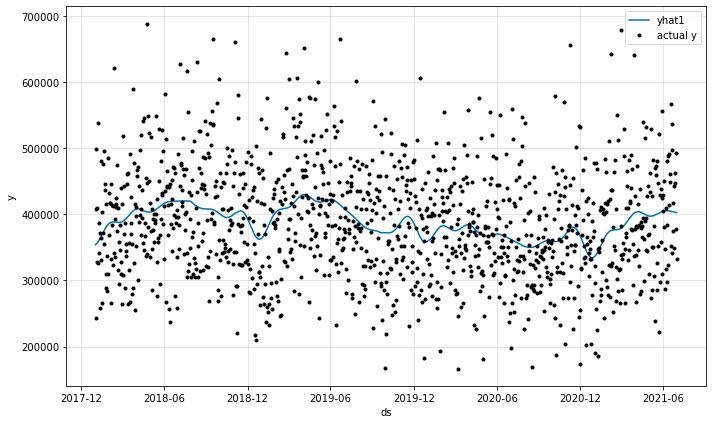

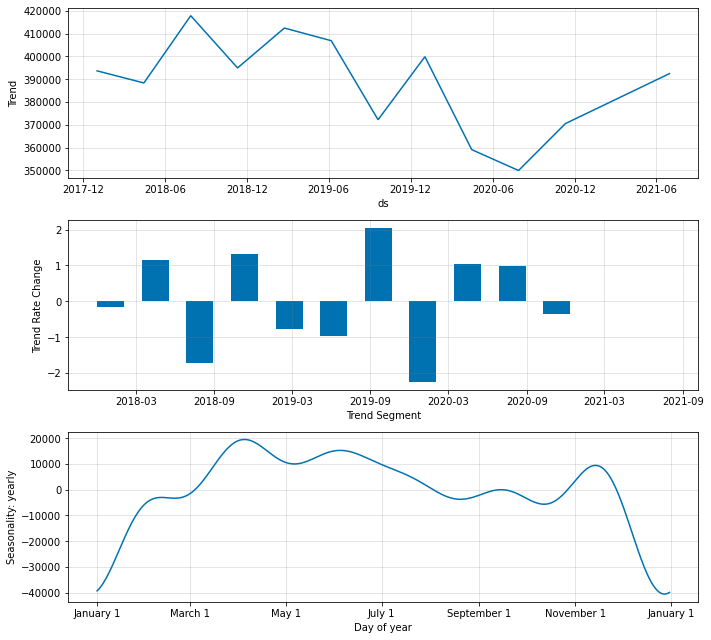

In [120]:
#학습 데이터셋 예측 결과 시각화
train_pred = m.predict(train)
#fig = m.plot(train_pred)
fig1 = m.plot(train_pred[-30*24*6:])
#fig2 = m.plot(train_pred[-7*24*6:])
#comp = m.plot_components(train_pred)
param = m.plot_parameters()

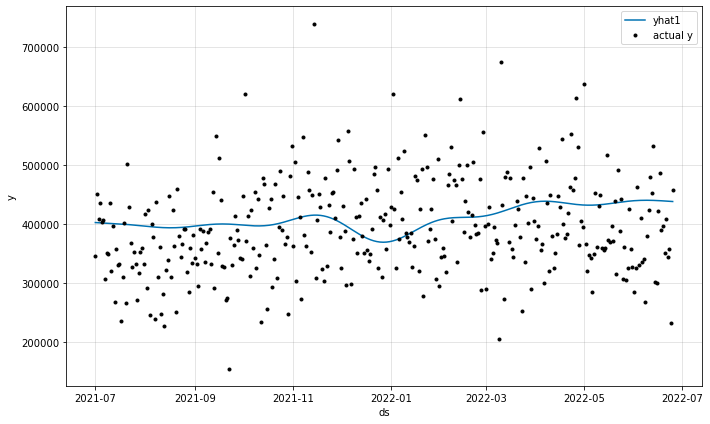

In [121]:
#테스트 데이터셋 예측 결과 시각화
test_pred = m.predict(test)
fig = m.plot(test_pred)
#fig1 = m.plot(test_pred[-14*24*6:])
#fig2 = m.plot(test_pred[-7*24*6:])
#comp = m.plot_components(test_pred)

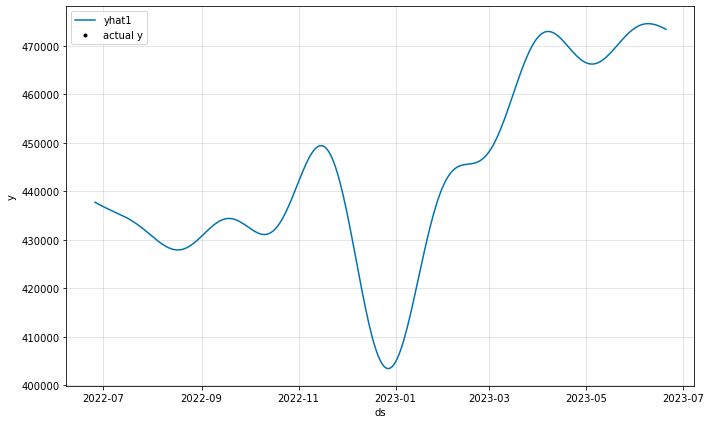

In [130]:
df_future = m.make_future_dataframe(test, periods=360)
forecast = m.predict(df_future)
fig_forecast = m.plot(forecast)

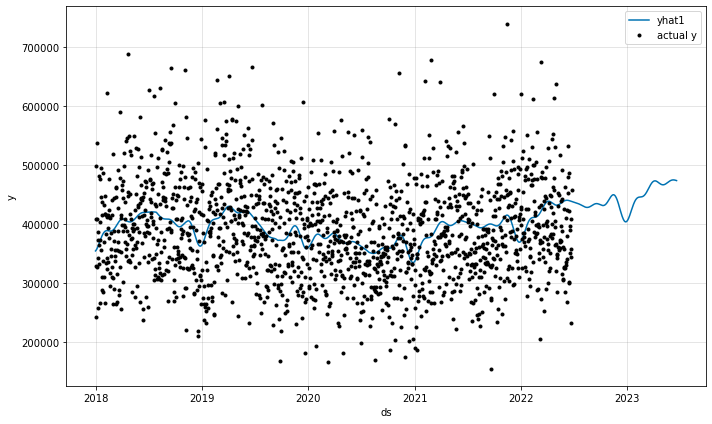

In [123]:
all_pred = pd.concat([train_pred, test_pred, forecast])
fig_all_pred = m.plot(all_pred)